# Assignment 1: Crack Detection in Concrete Inspection Images

In this assignment, we will take part of a [Kaggle competition](https://www.kaggle.com/t/28f427df84ea4d06a395beb6a0436cd3). For those of you who never heard about it before, Kaggle is an online data science community with lots of interesting data sets, codes, open competitions, etc. In Kaggle, I set up a competition for this assignment---you can download necessary data for this assignment from it, view samples, and submit your results to get them graded.

To get started, open [this link](https://www.kaggle.com/t/28f427df84ea4d06a395beb6a0436cd3) and browse through the competition page. The webpage will walk you through the details of data and how to make a submission.

To download the dataset, there are basically two ways. An easy (but perhaps more time-consuming) way is to just click `Data` tab in the competition page, and hit `Download All` button. It will then download the entire dataset in a zip file, which you can extract to a desired location.

Alaternatively, you can also use Kaggle CLI (Command Line Interface), which can be installed via the following command in terminal:
```bash
pip install kaggle
```
After installing it, go to the `Account` tab of your user profile on Kaggle and select `Create New Token`. This will trigger the download of `kaggle.json`, a file containing your API credentials. The Kaggle CLI tool will look for this token at `~/.kaggle/kaggle.json` on Linux, OSX, and other UNIX-based operating systems, and at `C:\Users\<username>\.kaggle\kaggle.json` on Windows. If you are using Google Colab, see '[How to use the Kaggle API from Colab](https://colab.research.google.com/github/corrieann/kaggle/blob/master/kaggle_api_in_colab.ipynb).'

Once the configuration is complete, running the following command in terminal will let you download the dataset:
```bash
kaggle competitions download -c <competition-name> -p <download-folder>
```

In our case, executing the following sell will let you download the competition dataset:

In [1]:
!kaggle competitions download -c padl-assignment-1-concrete-crack-detection -p ./data


  0%|          | 0.00/4.87M [00:00<?, ?B/s]
100%|██████████| 4.87M/4.87M [00:00<00:00, 80.7MB/s]


Now you can unzip the file using Python `zipfile` library.

In [2]:
import zipfile

data_dir = 'data/padl-assignment-1-concrete-crack-detection'

with zipfile.ZipFile('data/padl-assignment-1-concrete-crack-detection.zip', 'r') as zip_ref:
    zip_ref.extractall(data_dir)

In [22]:
import os
import platform
if platform.system() == "Windows":
    !dir "{data_dir}"
else:
    !ls "{data_dir}"

 Volume in drive C is Windows
 Volume Serial Number is 3E87-B3E7

 Directory of c:\Users\mwn4yc\codes\padl\assignments\data\padl-assignment-1-concrete-crack-detection

01/17/2025  03:27 PM    <DIR>          .
01/17/2025  03:27 PM    <DIR>          ..
01/17/2025  03:27 PM             1,896 sample_submission.csv
01/17/2025  03:27 PM    <DIR>          test
01/17/2025  03:27 PM    <DIR>          train
               1 File(s)          1,896 bytes
               4 Dir(s)  1,205,315,358,720 bytes free


### Load Data

Okay, now that we have downloaded all the competition data from Kaggle, let's start loading them. As our usual step, we are going to import PyTorch and find an available device.

In [24]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda") 
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else: 
    device = torch.device("cpu")
print("Device:", device)

Device: cuda


In [25]:
from torchvision import datasets, transforms
from torch.utils.data import random_split

image_width = 64     # TODO: Change the image size to optimize the performance
image_height = 64    # TODO: Change the image size to optimize the performance
batch_size = 32      # TODO: Change the batch size to optimize the performance
transform = transforms.Compose([   # TODO: Explore other image transformations to optimize the performance
    transforms.Grayscale(),
    transforms.Resize((image_height, image_width)),
    transforms.ToTensor(),
    transforms.Lambda(torch.flatten)  # TODO: We are flattening image to a 1D vector to make it compatible with MLP. For CNN, remove this line.
])
dataset = datasets.ImageFolder(data_dir, transform=transform)

dataset_size = len(dataset)
train_size = int(0.8*dataset_size)
val_size = dataset_size - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

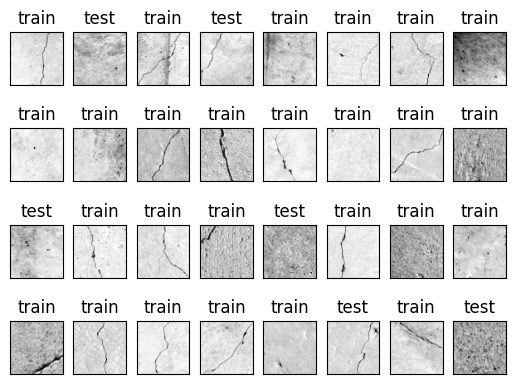

In [26]:
import matplotlib.pyplot as plt
images, labels = next(iter(train_loader))
plt.figure()
for i, (image, label) in enumerate(zip(images, labels)):
    plt.subplot(4,8,i+1)
    plt.imshow(image.reshape(image_height,image_width),cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title(dataset.classes[label])

### Model Design

Below is a simple baseline model for testing. Design your own model here to make it perform better.

In [28]:
import torch.nn as nn

class SimpleClassifier(nn.Module):

    def __init__(self, num_inputs, num_hidden, num_outputs):
        super().__init__()
        # TODO: Try different architecture design
        self.linear1 = nn.Linear(num_inputs, num_hidden)
        self.act_fn = nn.Tanh()
        self.linear2 = nn.Linear(num_hidden, num_outputs)

    def forward(self, x):
        # TODO: Try different architecture design
        x = self.linear1(x)
        x = self.act_fn(x)
        x = self.linear2(x)
        return x
    
model = SimpleClassifier(num_inputs=image_height*image_width, num_hidden=4096, num_outputs=1)

# Printing a module shows all its submodules
print(model)

SimpleClassifier(
  (linear1): Linear(in_features=4096, out_features=4096, bias=True)
  (act_fn): Tanh()
  (linear2): Linear(in_features=4096, out_features=1, bias=True)
)


### Train

Finally, it's time to train the model!

In [29]:
# TODO: Try different optimizers and parameter combinations
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [31]:
model.to(device)    # Load the model to the device

loss_module = nn.BCEWithLogitsLoss()

# Training loop
num_epochs = 10     # TODO: Increase the number of epochs (e.g., 1000) to see if it converges better
for epoch in range(num_epochs):
    model.train()       # Set model to train mode
    running_loss = 0
    for i, (data_inputs, data_labels) in enumerate(train_loader):

        ## Step 1: Move input data to device (only strictly necessary if we use GPU)
        data_inputs = data_inputs.to(device)
        data_labels = data_labels.to(device)

        ## Step 2: Run the model on the input data
        preds = model(data_inputs)
        preds = preds.squeeze(dim=1) # Output is [Batch size, 1], but we want [Batch size]

        ## Step 3: Calculate the loss
        loss = loss_module(preds, data_labels.float())

        ## Step 4: Perform backpropagation
        # Before calculating the gradients, we need to ensure that they are all zero.
        # The gradients would not be overwritten, but actually added to the existing ones.
        optimizer.zero_grad()
        # Perform backpropagation
        loss.backward()

        ## Step 5: Update the parameters
        optimizer.step()

        ## Step 6: Print the progress before moving to the next iteration
        running_loss += loss.detach().cpu().numpy()
        print(f"Epoch {epoch} loss: {running_loss/(i+1)}", end='\r')
    avg_train_loss = running_loss / i

    # Repeat the same, but this time on the validation data to evaluate the progress
    model.eval()       # Set model to evaluation mode
    running_val_loss = 0
    for i, (data_inputs, data_labels) in enumerate(val_loader):
        
        data_inputs = data_inputs.to(device)
        data_labels = data_labels.to(device)

        preds = model(data_inputs)
        preds = preds.squeeze(dim=1)

        loss = loss_module(preds, data_labels.float())

        # For validation data, we skip backpropagation (we are not training!)

        running_val_loss += loss.detach().cpu().numpy()
        print(f"Epoch {epoch} - loss: {avg_train_loss}, val: {running_val_loss/(i+1)}", end='\r')
    print('')

Epoch 0 - loss: 0.5183268806764058, val: 0.4380139634013176
Epoch 1 - loss: 0.4917296362774713, val: 0.43590579926967624
Epoch 2 - loss: 0.49487761088779997, val: 0.43705650418996813
Epoch 3 - loss: 0.4936491421290806, val: 0.4361954927444458
Epoch 4 - loss: 0.4948613686220987, val: 0.43579614907503135
Epoch 5 - loss: 0.4921263147677694, val: 0.43588682264089584
Epoch 6 - loss: 0.4916093626192638, val: 0.43588546663522726
Epoch 7 - loss: 0.492759781224387, val: 0.43658541887998584
Epoch 8 - loss: 0.4947310537099838, val: 0.4382167458534241
Epoch 9 - loss: 0.49087546340056826, val: 0.43579337000846863


In [96]:
def eval_model(model, data_loader):
    model.eval() # Set model to eval mode
    true_preds, num_preds = 0., 0.

    with torch.no_grad(): # Deactivate gradients for the following code
        for data_inputs, data_labels in data_loader:

            # Determine prediction of model on dev set
            data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1)
            preds = torch.sigmoid(preds) # Sigmoid to map predictions between 0 and 1
            pred_labels = (preds >= 0.5).long() # Binarize predictions to 0 and 1

            # Keep records of predictions for the accuracy metric (true_preds=TP+TN, num_preds=TP+TN+FP+FN)
            true_preds += (pred_labels == data_labels).sum()
            num_preds += data_labels.shape[0]

    acc = true_preds / num_preds
    print(f"Accuracy of the model: {100.0*acc:4.2f}%")

In [97]:
eval_model(model, train_loader)

Accuracy of the model: 57.25%


In [98]:
eval_model(model, val_loader)

Accuracy of the model: 57.58%


### Submission